# Correlation Network Analysis

Gene network analysis is a method designed to identify sub-networks (modules) of correlated genes, which are likely to be co-expressed.
This can be helpful in identification of sub-networks (modules) of genes that contribute to disease.
In this example, we will cover how to create a pairwise correlation matrix of genes, as well as how to associate them with disease.

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import networkx as nx
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import json
import scipy
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import multipletests
import random

In [2]:
#Load in the required data
datExpr = pd.read_csv('/ReCoDE-Gene-Network-Analysis/data/data/Bcell_datExpr_pseudobulk.csv', index_col = 0)
metadata = pd.read_csv('/ReCoDE-Gene-Network-Analysis/data/data/Bcell_metadata_pseudobulk.csv', index_col = 0)

In [3]:
datExpr

,ISG15,LINC01342,TTLL10-AS1,TNFRSF18,CALML6,CHD5,ICMT-DT,MIR34AHG,RBP7,MTOR-AS1,...,FRMPD3,TSC22D3,KLHL13,AKAP14,RHOXF1-AS1,TMEM255A,SMIM10L2B-AS1,IL9R_ENSG00000124334,DDX3Y,EIF1AY
donor_id,,,,,,,,,,,,,,,,,,,,,
CH-20-001,6.380902,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,53.239480,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,21.632603,17.641195
CH-20-002,12.606751,2.33599,0.000000,0.000000,0.00000,0.000000,1.089918,0.000000,1.158743,1.173824,...,0.000000,112.643970,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,45.432410,22.809190
CH-20-004,12.302510,0.00000,0.000000,21.512184,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,42.873410,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,15.570595,20.173725
CH-20-005,18.603716,1.16925,1.232658,4.975880,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.112746,190.337740,0.000000,0.0000,1.191559,0.000000,0.000000,0.000000,6.931139,1.071742
CH-21-002,13.705297,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,44.942260,0.000000,0.0000,0.000000,0.000000,0.000000,1.323198,0.000000,0.000000
CH-21-006,4.377715,0.00000,0.000000,23.782143,0.00000,0.000000,0.000000,0.000000,1.023552,0.000000,...,0.000000,12.741602,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,5.349793,12.981407
CH-21-008,18.058025,0.00000,0.000000,44.614340,0.00000,1.201673,0.000000,0.000000,0.000000,0.000000,...,0.000000,76.893720,0.000000,0.0000,0.000000,0.000000,0.000000,1.080360,1.188176,2.377049
CH-21-013,21.395964,0.00000,0.000000,30.426510,0.00000,0.000000,1.235703,0.000000,0.000000,0.000000,...,0.000000,54.458330,0.000000,0.0000,0.000000,0.000000,1.117969,1.236817,23.543072,53.250420
CH-21-014,13.436963,0.00000,0.000000,11.067089,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,32.248600,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,17.709280,21.636190


In [4]:
metadata

,nCount_RNA,nFeature_RNA,donor_id.1,MUTATION,percent.mt,scType_celltype,tissue_type,cell_type,tissue,development_stage,male,female,CH,normal,DNMT3A,TET2,NoMutation
donor_id,,,,,,,,,,,,,,,,,
CH-20-001,2490.0,1403,CH-20-001,DNMT3A R882C,6.119578,Naive B cells,tissue,B cell,blood,60,1,0,1,0,1,0,0
CH-20-002,1192.0,629,CH-20-002,"DNMT3A R729W (4%), DNMT3A R736C (2%)",3.803975,Naive B cells,tissue,B cell,blood,68,1,0,1,0,1,0,0
CH-20-004,1833.0,985,CH-20-004,"TET2 R1516X (30%), TET2 Q659X (29%), SRSF2 P95...",5.335196,Naive B cells,tissue,B cell,blood,85,1,0,1,0,0,1,0
CH-20-005,1966.0,886,CH-20-005,TET2 V1900F (2%),5.314136,Naive B cells,tissue,B cell,blood,58,0,1,1,0,0,1,0
CH-21-002,1912.0,938,CH-21-002,none,5.657238,Naive B cells,tissue,B cell,blood,48,0,1,0,1,0,0,1
CH-21-006,1356.0,709,CH-21-006,DNMT3A R882H (13%),5.211849,Naive B cells,tissue,B cell,blood,67,0,1,1,0,1,0,0
CH-21-008,1117.0,575,CH-21-008,none,8.398348,Naive B cells,tissue,B cell,blood,70,0,1,0,1,0,0,1
CH-21-013,1321.0,816,CH-21-013,none,4.663212,Naive B cells,tissue,B cell,blood,73,1,0,0,1,0,0,1
CH-21-014,1064.0,623,CH-21-014,"SRSF2 P95R (40%), TET2 L957Ifs*15 (51%)",4.146577,Naive B cells,tissue,B cell,blood,74,1,0,1,0,0,1,0


Correlation is a statistical measure that describes the extent to which two variables change together. It indicates the strength and direction of a linear relationship between two variables.
Correlation analysis for coexpression networks is a method used to study the relationships between genes or proteins by analysing their expression levels across various conditions, tissues, or time points.
We will be exploring correlation based co-expression networks within this exercise.

# Step 1: Calculate Correlation

In [5]:
#You can use the corr function to calculate pairwise pearson correlations between the genes.
correlation_matrix = datExpr.corr()

Lets view the correlation matrix. You will see that there is a diagonal of the value 1, due to the calculating the correlation between the same gene.

In [6]:
correlation_matrix

,ISG15,LINC01342,TTLL10-AS1,TNFRSF18,CALML6,CHD5,ICMT-DT,MIR34AHG,RBP7,MTOR-AS1,...,FRMPD3,TSC22D3,KLHL13,AKAP14,RHOXF1-AS1,TMEM255A,SMIM10L2B-AS1,IL9R_ENSG00000124334,DDX3Y,EIF1AY
ISG15,1.000000,-0.092502,-0.106168,0.645245,-0.093365,-0.102921,-0.080086,-0.052127,0.180437,-0.076886,...,0.029464,0.334351,-0.034003,-0.034003,-0.049428,-0.034003,-0.036643,0.187654,0.602785,0.673038
LINC01342,-0.092502,1.000000,0.281837,-0.183851,-0.059383,-0.085815,0.556591,-0.081739,0.227693,0.890407,...,0.186025,0.251452,-0.059383,-0.059383,0.416022,-0.059383,-0.059383,-0.124612,0.173334,-0.071186
TTLL10-AS1,-0.106168,0.281837,1.000000,-0.181582,-0.062692,-0.090597,-0.090459,-0.086293,-0.140100,-0.062692,...,0.383858,0.218250,-0.062692,-0.062692,0.743859,-0.062692,-0.062692,-0.131555,-0.209975,-0.179643
TNFRSF18,0.645245,-0.183851,-0.181582,1.000000,-0.133171,0.079331,-0.082125,-0.003088,-0.006450,-0.143499,...,0.295032,0.385228,0.309068,0.309068,-0.116850,0.309068,0.019452,0.157654,0.316701,0.583206
CALML6,-0.093365,-0.059383,-0.062692,-0.133171,1.000000,-0.062831,-0.062735,-0.059846,-0.097162,-0.043478,...,-0.077984,0.248300,-0.043478,-0.043478,-0.043478,-0.043478,-0.043478,-0.091237,-0.159078,-0.117442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM255A,-0.034003,-0.059383,-0.062692,0.309068,-0.043478,-0.062831,-0.062735,-0.059846,-0.097162,-0.043478,...,-0.077984,0.230799,1.000000,1.000000,-0.043478,1.000000,-0.043478,-0.091237,0.256518,0.562305
SMIM10L2B-AS1,-0.036643,-0.059383,-0.062692,0.019452,-0.043478,-0.062831,0.737278,-0.059846,-0.097162,-0.043478,...,-0.077984,-0.094460,-0.043478,-0.043478,-0.043478,-0.043478,1.000000,0.523393,0.037215,0.130174
IL9R_ENSG00000124334,0.187654,-0.124612,-0.131555,0.157654,-0.091237,0.269090,0.339578,-0.125584,-0.073338,-0.091237,...,-0.163645,-0.006889,-0.091237,-0.091237,-0.091237,-0.091237,0.523393,1.000000,0.050801,0.197187
DDX3Y,0.602785,0.173334,-0.209975,0.316701,-0.159078,-0.210786,0.200461,-0.228903,0.451454,0.254247,...,-0.301277,0.402058,0.256518,0.256518,-0.127493,0.256518,0.037215,0.050801,1.000000,0.819119


# Step 2: Calculate Distance Matrix

Now that we have the correlation matrix, we need to calculate the distance matrix.
A distance matrix is a mathematical representation that captures the pairwise distances between a set of objects. 
In hierarchical clustering, distance matrices are used to determine which objects to merge or split based on their pairwise distances.
So, we will be using the distance matrix in order to calculate clusters between genes, which will form our networks. These are commonly also called communities.

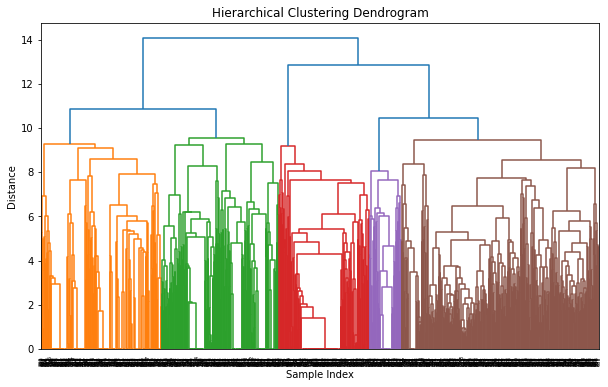

In [7]:
# Perform hierarchical clustering using the dissimilarity values
distance_matrix = 1 - correlation_matrix  # Convert correlation to distance

#The linkage function is used to perform hierarchical clustering on the distance matrix. 
linkage_matrix = sch.linkage(distance_matrix, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Step 3: Threshold Correlations

Due to all of the vast correlations, the networks will be very messy each having lots of edges with varying correlation strengths.
Not all of these are of interest, such as weak correlations. So we would solely like to focus on the strong correlations.

In [8]:
# Define threshold for significant edges (you can adjust this based on your requirement)
threshold = 1

# Threshold the correlation matrix to determine significant edges
significant_edges = correlation_matrix > threshold

Lets have a look at the significant_edges dataframe.
You can now see that this produces a boolean dataframe which states whether the values are greater than the threshold or not.

In [9]:
significant_edges

,ISG15,LINC01342,TTLL10-AS1,TNFRSF18,CALML6,CHD5,ICMT-DT,MIR34AHG,RBP7,MTOR-AS1,...,FRMPD3,TSC22D3,KLHL13,AKAP14,RHOXF1-AS1,TMEM255A,SMIM10L2B-AS1,IL9R_ENSG00000124334,DDX3Y,EIF1AY
ISG15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LINC01342,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TTLL10-AS1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TNFRSF18,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CALML6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM255A,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
SMIM10L2B-AS1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
IL9R_ENSG00000124334,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
DDX3Y,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Step 4: Construct Network

networkx is a python library designed for network analysis.
Construct the network from significant edges.

In [10]:
G = nx.Graph()

# Loop through significant edges and add edges to the graph
for i in range(significant_edges.shape[0]):
    for j in range(significant_edges.shape[1]):
        if significant_edges.values[i, j]:
            gene1 = significant_edges.index[i]
            gene2 = significant_edges.columns[j]
            
            # Find the position of gene1 and gene2 in the correlation matrix
            i_corr = np.where(correlation_matrix.index == gene1)[0][0]
            j_corr = np.where(correlation_matrix.columns == gene2)[0][0]
            
            # Add the edge to the graph
            G.add_edge(gene1, gene2, weight=correlation_matrix.iloc[i_corr, j_corr])

# Display the number of nodes and edges in the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 270
Number of edges: 1291


# Step 5: Network Analysis

Analyse the network:
For example, you can identify clusters/modules using community detection algorithms

In [11]:
communities = nx.algorithms.community.greedy_modularity_communities(G)

In [12]:
communities

[frozenset({'AKAP14',
            'ANKRD29',
            'ANO1',
            'ARHGAP23',
            'ARHGEF39',
            'C21orf62',
            'CC2D2B',
            'CCNA1',
            'CDH6',
            'CFAP99',
            'CNKSR3',
            'CYYR1',
            'DBX2',
            'DENND6A-AS1',
            'DEPDC7',
            'DTNA',
            'FNDC5',
            'GJB6',
            'GJC2',
            'GNG12',
            'HCG9',
            'HYDIN',
            'IGLC4',
            'IGLV5-37',
            'KLHL13',
            'KRT2',
            'LAMA2',
            'LCN2',
            'LIM2',
            'LIN28A',
            'LINC00640',
            'LINC00997',
            'LINC01133',
            'LINC01832',
            'LINC01891',
            'LINC02267',
            'LNCOC1',
            'MGAM',
            'MOBP',
            'MUCL3',
            'NGFR',
            'NKD2',
            'NKX6-3',
            'OPA1-AS1',
            'OR2B11',
            

In [13]:
# Initialise a new graph for community visualisation
community_graph = nx.Graph()

In [14]:
# Add edges between communities based on their connectivity
for i, community in enumerate(communities):
    for node in community:
        community_graph.add_node(node)
        for neighbor in G.neighbors(node):
            if neighbor in community:
                community_graph.add_edge(node, neighbor, weight=G[node][neighbor]['weight'])


In [15]:
# Initialise an empty list to store separated communities
separated_communities = []

# Iterate over the detected communities
for community in communities:
    # Convert the set of nodes into a list and append it to the list of lists
    separated_communities.append(list(community))

In [16]:
# Print or use the separated communities as needed
print(separated_communities)

[['NKX6-3', 'ZC2HC1B', 'ZSCAN10', 'HCG9', 'CC2D2B', 'DBX2', 'MOBP', 'STAP2', 'LCN2', 'ZNF462', 'TMEM72-AS1', 'LNCOC1', 'SLC28A2', 'SLC10A5', 'SRRM5', 'SLC17A7', 'OPA1-AS1', 'DEPDC7', 'LIN28A', 'SLC6A3', 'GJB6', 'TMEM255A', 'IGLC4', 'LINC00640', 'DENND6A-AS1', 'FNDC5', 'LAMA2', 'CYYR1', 'CNKSR3', 'RNF182', 'TECTA', 'KRT2', 'PRRT3-AS1', 'LINC02267', 'MUCL3', 'CFAP99', 'CCNA1', 'SLC26A8', 'GNG12', 'PHACTR3', 'LINC01133', 'C21orf62', 'ANKRD29', 'NGFR', 'NKD2', 'GJC2', 'LIM2', 'ANO1', 'LINC00997', 'STARD6', 'ARHGAP23', 'HYDIN', 'KLHL13', 'IGLV5-37', 'PLSCR2', 'TDRP', 'REG1A', 'LINC01832', 'ARHGEF39', 'CDH6', 'LINC01891', 'MGAM', 'AKAP14', 'TDRD1', 'PRLR', 'RARRES2', 'SLC2A4', 'OR2B11', 'DTNA', 'PTGES'], ['ACTN3', 'PDK4-AS1', 'C10orf105', 'ACVR2B-AS1', 'LINC02348', 'DPYD-IT1', 'UBE2Q2P16', 'PRKD3-DT', 'LINC01986', 'CALML6', 'EPHB2', 'PAPPA-AS1', 'DLGAP2', 'MROH8', 'RAB6C', 'ZNF503', 'H3C8', 'LINC02569', 'CDC42EP1', 'TFAP2A', 'ESCO2', 'WNT3A', 'SLC12A3', 'RGPD6', 'ICA1-AS1', 'FOXD3', 'LINC026

In [17]:
len(communities)

18

In [18]:
import pickle
# Save the separated_communities list as a pkl file
file_path = '/ReCoDE-Gene-Network-Analysis/data/other/separated_communities.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(separated_communities, file)

# Step 6: Investigate Chosen Community/Sub-Network

In [19]:
# Choose the index of the community you want to visualise
community_index = 0  # Change this to the index of the community you want to visualise

# Get the nodes in the selected community
selected_community = list(communities[community_index])

# Create a subgraph containing only the nodes and edges within the selected community
subgraph = G.subgraph(selected_community)

In [20]:
# Assuming subgraph is already defined
num_nodes = subgraph.number_of_nodes()
print(f"The number of nodes in the subgraph is: {num_nodes}")

The number of nodes in the subgraph is: 70


# Step 7: Visualise the Community/Sub-Network

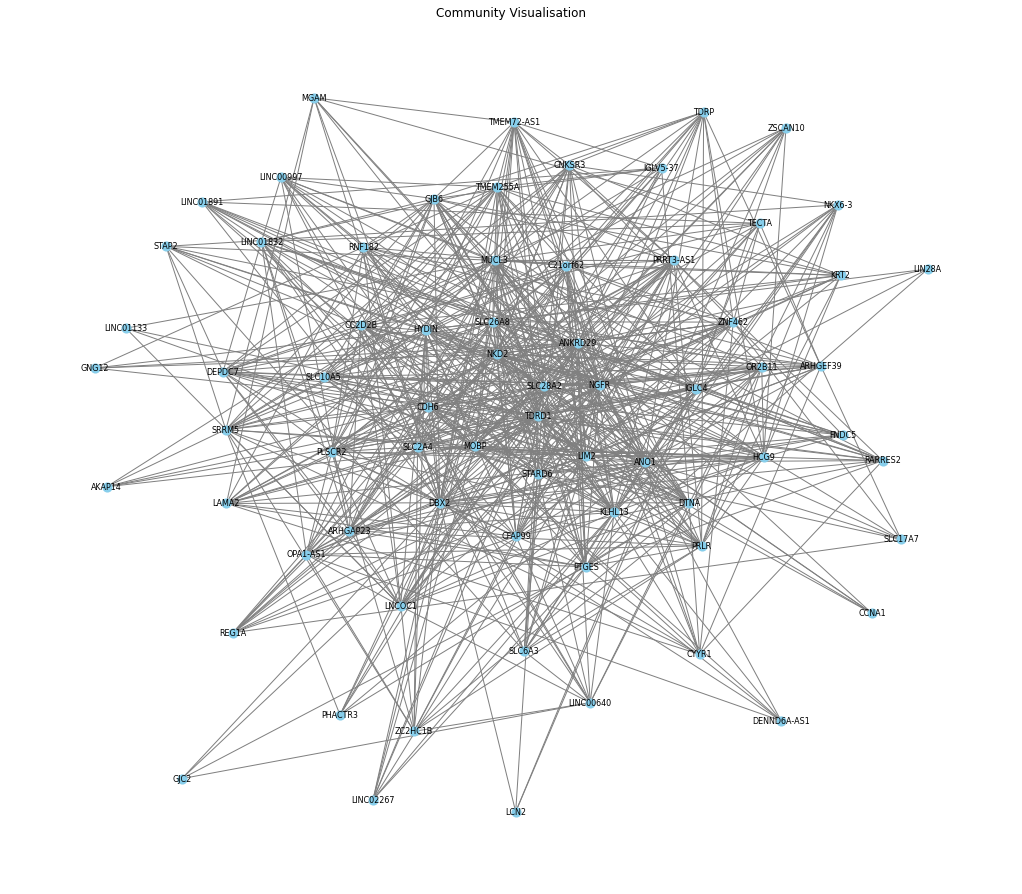

In [21]:
# Visualise the subgraph
pos = nx.spring_layout(subgraph, k=0.8, iterations=20)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.1, font_size=8)
plt.title('Community Visualisation')
plt.show()

Play around with different layouts and see how the visualisation is affected.
For example, there is circular_layout. Check out https://networkx.org/documentation/stable/tutorial.html#drawing-graphs for more information.

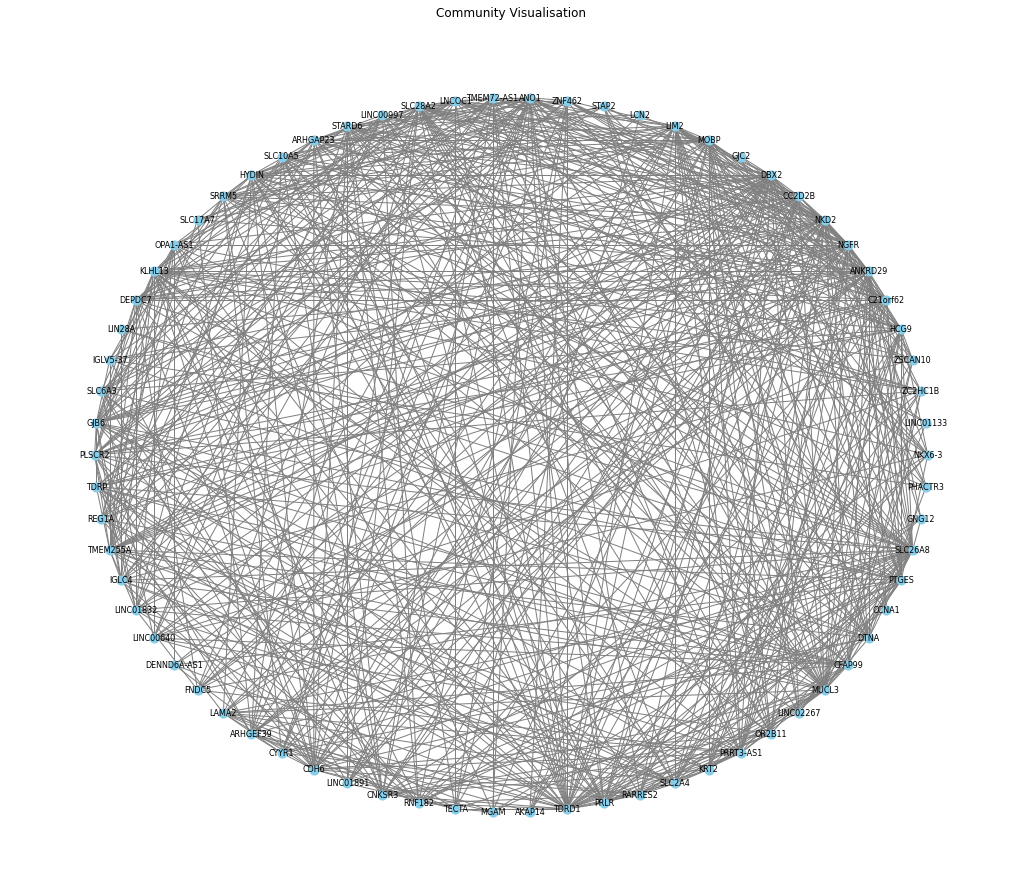

In [22]:
# Visualise the subgraph
pos = nx.circular_layout(subgraph)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.1, font_size=8)
plt.title('Community Visualisation')
plt.show()

As can be seen here, the circular layout is not really suitable due to the high number of genes within the sub-network that have high density of edges.

Since the subnetwork itself is too large to visualise, we shall visualise a random sample of the subnetwork.

In [23]:
# Select 10 random nodes from the original subgraph
selected_nodes = random.sample(subgraph.nodes(), 10)

# Create a new subgraph containing only the selected nodes and their neighbors
reduced_subgraph = subgraph.subgraph(selected_nodes)

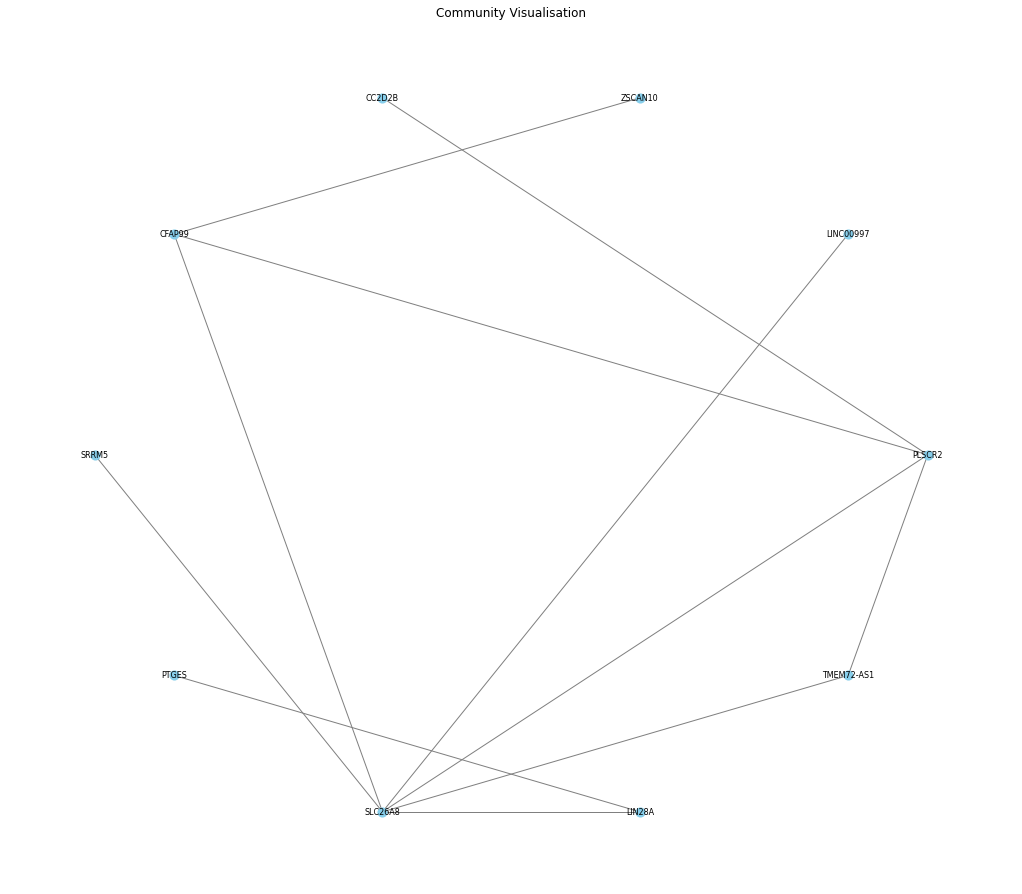

In [24]:
# Visualise the subgraph
pos = nx.circular_layout(reduced_subgraph)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(reduced_subgraph, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.1, font_size=8)
plt.title('Community Visualisation')
plt.show()

Try out a different visualisation technique with the randomly sampled subnetwork

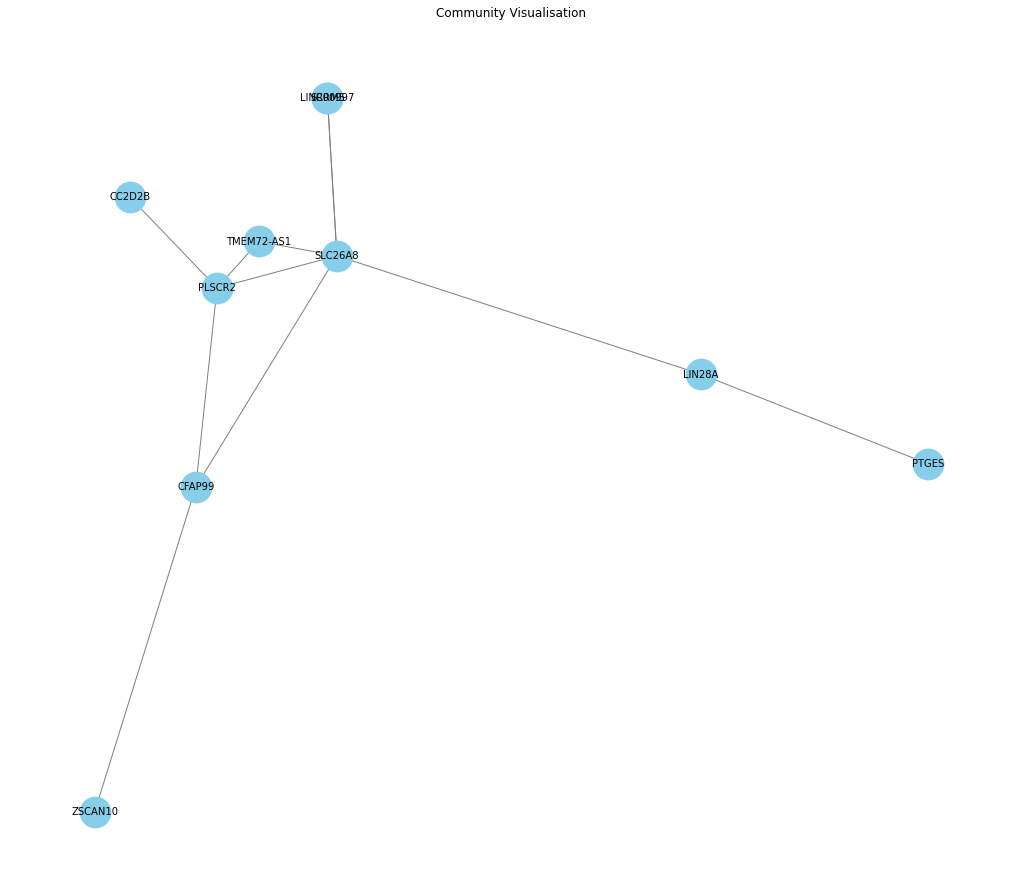

In [25]:
# Visualise the subgraph
pos = nx.spectral_layout(reduced_subgraph)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(reduced_subgraph, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', linewidths=0.1, font_size=10)
plt.title('Community Visualisation')
plt.show()

External Reading Links:

- WGCNA package: https://web.archive.org/web/20230323144343/horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/
- WGCNA paper: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-559
- Correlation analysis: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5079093/
- Quick introduction page to correlations in statistics: https://www.jmp.com/en_gb/statistics-knowledge-portal/what-is-correlation.html

Exercise Questions:
1. What is a gene co-expression network, and why is it important in understanding biological systems?
2. Explain the concept of Pearson correlation and its use in gene expression analysis.
3. What other correlation measures could be used?
4. Why do we convert a correlation matrix to a distance matrix in hierarchical clustering?
5. What other distance measures could be used?
6. 6. What is hierarchical clustering, and how is it applied in the context of gene co-expression networks?
7. Are there other community-based algorithms that could be used instead?
8. Show a worked through example testing different correlation measures, distance measures and community algorithms and see how this affects the networks produced.

Answers:
1. A gene co-expression network is a type of biological network where nodes represent genes and edges represent significant co-expression relationships between them. These networks are important because they help identify groups of genes (modules) that are co-expressed under various conditions, which can reveal functional relationships and regulatory mechanisms within the biological system. Understanding these networks can lead to insights into gene functions, interactions, and their roles in diseases.
2. Pearson correlation is a measure of the linear relationship between two variables, providing a value between -1 and 1. In gene expression analysis, Pearson correlation is used to quantify the degree to which the expression levels of two genes vary together across different samples or conditions. A value close to 1 indicates strong positive correlation, -1 indicates strong negative correlation, and 0 indicates no linear correlation. This measure helps identify gene pairs that might be co-regulated or involved in the same biological processes.
3. Spearman Rank Correlation measures the strength and direction of the monotonic relationship between two ranked variables. It is useful for ordinal data or when the relationship isn't linear. Kendall Tau Correlation measures the association between two ranked variables. It is suitable for small sample sizes or data with many tied ranks.
4. We convert a correlation matrix to a distance matrix because hierarchical clustering algorithms require a measure of dissimilarity between pairs of genes. The distance matrix represents this dissimilarity, with smaller values indicating more similar (correlated) gene expression profiles. This conversion allows the clustering algorithm to group similar genes together based on their expression patterns, facilitating the identification of co-expressed gene modules.
5. Euclidean Distance is the straight-line distance between two points in Euclidean space. Manhattan Distance is the sum of absolute differences between the coordinates of two points. Minkowski Distance is a generalisation that includes both Euclidean and Manhattan distances. By providing a comprehensive way to quantify relationships between objects, distance matrices play a fundamental role in data analysis, pattern recognition, and various scientific research fields.
6. Hierarchical clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. It is applied in gene co-expression networks to group genes with similar expression patterns. The process starts with each gene as its own cluster and iteratively merges the most similar clusters based on their distance, forming a tree-like structure called a dendrogram. This helps visualise the relationships between genes and identify clusters of co-expressed genes.
7. The Louvain method is an efficient algorithm for community detection that optimises modularity. The Girvan-Newman algorithm detects communities by progressively removing edges with the highest betweenness centrality.


Question 8:

In [26]:
#Calculate correlation using Spearman Rank Correlation:
correlation_matrix2 = datExpr.corr(method = 'spearman')

In [27]:
correlation_matrix2

,ISG15,LINC01342,TTLL10-AS1,TNFRSF18,CALML6,CHD5,ICMT-DT,MIR34AHG,RBP7,MTOR-AS1,...,FRMPD3,TSC22D3,KLHL13,AKAP14,RHOXF1-AS1,TMEM255A,SMIM10L2B-AS1,IL9R_ENSG00000124334,DDX3Y,EIF1AY
ISG15,1.000000,0.016319,-0.056208,0.686548,-0.165674,-0.037170,0.049862,-0.069807,0.222848,-0.075307,...,0.369104,0.486957,0.165674,0.165674,0.105429,0.165674,0.135552,0.266461,0.116547,0.203655
LINC01342,0.016319,1.000000,0.452741,-0.237069,-0.062810,-0.090737,0.452741,-0.090737,0.261696,0.722315,...,0.321733,0.320931,-0.062810,-0.062810,0.659505,-0.062810,-0.062810,-0.134016,0.140551,-0.009074
TTLL10-AS1,-0.056208,0.452741,1.000000,-0.149824,-0.062810,-0.090737,-0.090737,-0.090737,-0.153188,-0.062810,...,0.359584,0.269256,-0.062810,-0.062810,0.722315,-0.062810,-0.062810,-0.134016,-0.192238,-0.389263
TNFRSF18,0.686548,-0.237069,-0.149824,1.000000,-0.136595,0.265847,-0.063493,-0.040654,-0.004319,-0.273190,...,0.294203,0.108656,0.288367,0.288367,-0.045532,0.288367,0.166950,0.193963,0.016433,0.368349
CALML6,-0.165674,-0.062810,-0.062810,-0.136595,1.000000,-0.062810,-0.062810,-0.062810,-0.106040,-0.043478,...,-0.078603,0.195797,-0.043478,-0.043478,-0.043478,-0.043478,-0.043478,-0.092769,-0.165710,-0.165819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM255A,0.165674,-0.062810,-0.062810,0.288367,-0.043478,-0.062810,-0.062810,-0.062810,-0.106040,-0.043478,...,-0.078603,0.165674,1.000000,1.000000,-0.043478,1.000000,-0.043478,-0.092769,0.286227,0.316563
SMIM10L2B-AS1,0.135552,-0.062810,-0.062810,0.166950,-0.043478,-0.062810,0.722315,-0.062810,-0.106040,-0.043478,...,-0.078603,0.015061,-0.043478,-0.043478,-0.043478,-0.043478,1.000000,0.487035,0.135581,0.256265
IL9R_ENSG00000124334,0.266461,-0.134016,-0.134016,0.193963,-0.092769,0.267335,0.302235,-0.134016,-0.008485,-0.092769,...,-0.167714,0.181434,-0.092769,-0.092769,-0.092769,-0.092769,0.487035,1.000000,-0.108148,0.060307
DDX3Y,0.116547,0.140551,-0.192238,0.016433,-0.165710,-0.246645,0.279289,-0.265687,0.304952,0.256098,...,-0.395663,0.203523,0.286227,0.286227,-0.075323,0.286227,0.135581,-0.108148,1.000000,0.829598


Calculate distance matrix using Minkowski Distance

Convert correlation matrix to distance matrix
Here, we use 1 - correlation as the distance measure by first calculating the dissimilarity

In [28]:
distance_matrix2 = 1 - correlation_matrix2

# Calculate the Minkowski distance (p = 2 for Euclidean, p = 1 for Manhattan, etc.)
p = 3  # You can change this to any value of p
minkowski_distances = pdist(distance_matrix2, metric='minkowski', p=p)

# Convert back to square form
distance_matrix_minkowski = squareform(minkowski_distances)

In [29]:
distance_matrix_minkowski

array([[0.        , 4.97451632, 5.31047871, ..., 4.11670602, 4.41095818,
        4.07169558],
       [4.97451632, 0.        , 2.81633536, ..., 3.94219913, 3.39496526,
        4.15888346],
       [5.31047871, 2.81633536, 0.        , ..., 3.8634609 , 3.85574122,
        4.57033685],
       ...,
       [4.11670602, 3.94219913, 3.8634609 , ..., 0.        , 3.54310329,
        3.11503694],
       [4.41095818, 3.39496526, 3.85574122, ..., 3.54310329, 0.        ,
        1.79073525],
       [4.07169558, 4.15888346, 4.57033685, ..., 3.11503694, 1.79073525,
        0.        ]])

In [30]:
# Convert back to DataFrame to keep row and column names
#In order to do that save the row and column names from the original correlation matrix first:

row_labels = correlation_matrix.index
column_labels = correlation_matrix.columns

#Convert the distance matrix into a dataframe
distance_df = pd.DataFrame(distance_matrix_minkowski, index=row_labels, columns=column_labels)

In [31]:
distance_df

,ISG15,LINC01342,TTLL10-AS1,TNFRSF18,CALML6,CHD5,ICMT-DT,MIR34AHG,RBP7,MTOR-AS1,...,FRMPD3,TSC22D3,KLHL13,AKAP14,RHOXF1-AS1,TMEM255A,SMIM10L2B-AS1,IL9R_ENSG00000124334,DDX3Y,EIF1AY
ISG15,0.000000,4.974516,5.310479,2.479338,5.256966,5.137140,4.833509,6.154665,4.101156,5.488098,...,3.468319,3.099291,4.518263,4.518263,4.631243,4.518263,4.700795,4.116706,4.410958,4.071696
LINC01342,4.974516,0.000000,2.816335,5.643094,4.218496,4.195265,3.144677,4.192129,3.099887,2.302618,...,3.323716,4.142144,5.375076,5.375076,2.521129,5.375076,4.265176,3.942199,3.394965,4.158883
TTLL10-AS1,5.310479,2.816335,0.000000,5.641991,4.085150,3.976405,3.911277,3.799220,3.834896,3.974338,...,3.049130,4.647630,5.344209,5.344209,1.850177,5.344209,4.147613,3.863461,3.855741,4.570337
TNFRSF18,2.479338,5.643094,5.641991,0.000000,5.508208,4.336978,4.984989,5.608852,4.892775,5.900174,...,3.693057,4.861216,4.060531,4.060531,5.197886,4.060531,4.323955,3.887995,4.615055,3.413775
CALML6,5.256966,4.218496,4.085150,5.508208,0.000000,4.506604,4.367332,4.538077,4.231430,4.442941,...,4.214099,4.341695,5.488562,5.488562,4.288198,5.488562,4.537409,4.287737,4.430332,4.692939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM255A,4.518263,5.375076,5.344209,4.060531,5.488562,5.278605,5.328074,5.496537,5.339846,5.455101,...,5.181272,4.935519,0.000000,0.000000,5.318906,0.000000,5.310234,5.211184,3.732318,3.549149
SMIM10L2B-AS1,4.700795,4.265176,4.147613,4.323955,4.537409,3.970086,2.314571,3.959092,4.193764,4.310500,...,4.015744,5.423327,5.310234,5.310234,4.340555,5.310234,0.000000,2.426073,3.434198,3.095993
IL9R_ENSG00000124334,4.116706,3.942199,3.863461,3.887995,4.287737,2.609322,2.953918,3.696751,3.531675,3.992939,...,3.640487,4.822124,5.211184,5.211184,4.059895,5.211184,2.426073,0.000000,3.543103,3.115037
DDX3Y,4.410958,3.394965,3.855741,4.615055,4.430332,4.203337,2.995581,3.928682,2.754223,3.155120,...,4.137625,4.486492,3.732318,3.732318,4.001664,3.732318,3.434198,3.543103,0.000000,1.790735


/tmp/ipykernel_128889/2932722225.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix2 = sch.linkage(distance_df, method='average')


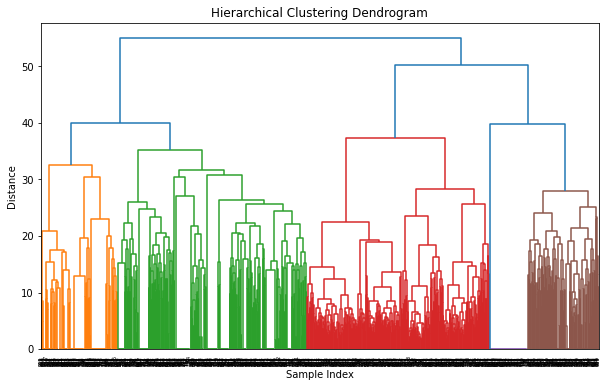

In [32]:
#The linkage function is used to perform hierarchical clustering on the distance matrix. 
linkage_matrix2 = sch.linkage(distance_df, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(linkage_matrix2)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [33]:
# Define threshold for significant edges (you can adjust this based on your requirement)
threshold = 0.7

# Threshold the correlation matrix to determine significant edges
significant_edges2 = correlation_matrix2 > threshold

In [34]:
significant_edges2

,ISG15,LINC01342,TTLL10-AS1,TNFRSF18,CALML6,CHD5,ICMT-DT,MIR34AHG,RBP7,MTOR-AS1,...,FRMPD3,TSC22D3,KLHL13,AKAP14,RHOXF1-AS1,TMEM255A,SMIM10L2B-AS1,IL9R_ENSG00000124334,DDX3Y,EIF1AY
ISG15,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LINC01342,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
TTLL10-AS1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
TNFRSF18,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CALML6,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM255A,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,True,False,False,False,False
SMIM10L2B-AS1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
IL9R_ENSG00000124334,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
DDX3Y,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True


In [35]:
#networkx is a python library designed for network analysis.
# Construct the network from significant edges.
G2 = nx.Graph()

# Loop through significant edges and add edges to the graph
for i in range(significant_edges2.shape[0]):
    for j in range(significant_edges2.shape[1]):
        if significant_edges2.values[i, j]:
            gene1 = significant_edges2.index[i]
            gene2 = significant_edges2.columns[j]
            
            # Find the position of gene1 and gene2 in the correlation matrix
            i_corr = np.where(correlation_matrix2.index == gene1)[0][0]
            j_corr = np.where(correlation_matrix2.columns == gene2)[0][0]
            
            # Add the edge to the graph
            G2.add_edge(gene1, gene2, weight=correlation_matrix2.iloc[i_corr, j_corr])

# Display the number of nodes and edges in the graph
print("Number of nodes:", G2.number_of_nodes())
print("Number of edges:", G2.number_of_edges())

Number of nodes: 1000
Number of edges: 30389


Analyse the network:
For example, you can identify clusters/modules using community detection algorithms
Connected_components is a quick and simple community detection algorithm. 
While this method may not be as sophisticated as algorithms like Louvain or Girvan-Newman, it can provide a basic partitioning of the graph into communities.

In [36]:
communities2 = list(nx.connected_components(G2))

In [37]:
communities2

[{'ABALON',
  'ACP5',
  'ACSL3-AS1',
  'ACSM3',
  'ACTA2-AS1',
  'ACTG1',
  'ACTN3',
  'ACVR2B-AS1',
  'ADAM19',
  'ADAMTS13',
  'ADARB2',
  'ADGRG3',
  'AFF3',
  'AHSP',
  'AIFM3',
  'AIM2',
  'AKAP13-AS1',
  'AKAP14',
  'ALDH1A1',
  'ALDH1L2',
  'ALDH8A1',
  'ALKAL2',
  'AMOTL1',
  'ANKRD28',
  'ANKRD29',
  'ANKRD44-DT',
  'ANKRD61',
  'ANO1',
  'ANO8',
  'ANXA1',
  'APOE',
  'AREG',
  'ARHGAP15',
  'ARHGAP17',
  'ARHGAP22',
  'ARHGAP23',
  'ARHGAP29',
  'ARHGAP39',
  'ARHGEF10L',
  'ARHGEF39',
  'ARID5B',
  'ARL4A',
  'ARL4C',
  'ARPP21',
  'ASGR1',
  'ASGR2',
  'ASIC3',
  'ASPN',
  'ATF7IP2',
  'ATP1A3',
  'ATP1B3',
  'ATP2B1-AS1',
  'AVP',
  'AZU1',
  'BANK1',
  'BASP1',
  'BAZ2B',
  'BCAR4',
  'BCL11B',
  'BCL2A1',
  'BCL7A',
  'BEX1',
  'BHLHE22',
  'BHLHE40',
  'BMP3',
  'BORCS5',
  'BRME1',
  'BSN',
  'BTG1-DT',
  'C10orf105',
  'C10orf71',
  'C12orf71',
  'C15orf48',
  'C16orf74',
  'C18orf63',
  'C19orf67',
  'C1QTNF7',
  'C1orf131',
  'C1orf162',
  'C1orf50-AS1',
  'C1orf56

In [38]:
# Initialise a new graph for community visualisation
community_graph2 = nx.Graph()

In [39]:
# Add edges between communities based on their connectivity
for i, community in enumerate(communities2):
    for node in community:
        community_graph2.add_node(node)
        for neighbor in G2.neighbors(node):
            if neighbor in community:
                community_graph2.add_edge(node, neighbor, weight=G2[node][neighbor]['weight'])


In [40]:
# Initialise an empty list to store separated communities
separated_communities = []

# Iterate over the detected communities
for community in communities:
    # Convert the set of nodes into a list and append it to the list of lists
    separated_communities.append(list(community))

In [41]:
# Print or use the separated communities as needed
print(separated_communities)

[['NKX6-3', 'ZC2HC1B', 'ZSCAN10', 'HCG9', 'CC2D2B', 'DBX2', 'MOBP', 'STAP2', 'LCN2', 'ZNF462', 'TMEM72-AS1', 'LNCOC1', 'SLC28A2', 'SLC10A5', 'SRRM5', 'SLC17A7', 'OPA1-AS1', 'DEPDC7', 'LIN28A', 'SLC6A3', 'GJB6', 'TMEM255A', 'IGLC4', 'LINC00640', 'DENND6A-AS1', 'FNDC5', 'LAMA2', 'CYYR1', 'CNKSR3', 'RNF182', 'TECTA', 'KRT2', 'PRRT3-AS1', 'LINC02267', 'MUCL3', 'CFAP99', 'CCNA1', 'SLC26A8', 'GNG12', 'PHACTR3', 'LINC01133', 'C21orf62', 'ANKRD29', 'NGFR', 'NKD2', 'GJC2', 'LIM2', 'ANO1', 'LINC00997', 'STARD6', 'ARHGAP23', 'HYDIN', 'KLHL13', 'IGLV5-37', 'PLSCR2', 'TDRP', 'REG1A', 'LINC01832', 'ARHGEF39', 'CDH6', 'LINC01891', 'MGAM', 'AKAP14', 'TDRD1', 'PRLR', 'RARRES2', 'SLC2A4', 'OR2B11', 'DTNA', 'PTGES'], ['ACTN3', 'PDK4-AS1', 'C10orf105', 'ACVR2B-AS1', 'LINC02348', 'DPYD-IT1', 'UBE2Q2P16', 'PRKD3-DT', 'LINC01986', 'CALML6', 'EPHB2', 'PAPPA-AS1', 'DLGAP2', 'MROH8', 'RAB6C', 'ZNF503', 'H3C8', 'LINC02569', 'CDC42EP1', 'TFAP2A', 'ESCO2', 'WNT3A', 'SLC12A3', 'RGPD6', 'ICA1-AS1', 'FOXD3', 'LINC026

In [42]:
len(communities2)

74

In [43]:
# Choose the index of the community you want to visualize
community_index2 = 0  # Change this to the index of the community you want to visualise

# Get the nodes in the selected community
selected_community2 = list(communities2[community_index2])

# Create a subgraph containing only the nodes and edges within the selected community
subgraph2 = G2.subgraph(selected_community2)

In [44]:
# Assuming subgraph is already defined
num_nodes = subgraph.number_of_nodes()
print(f"The number of nodes in the subgraph is: {num_nodes}")

The number of nodes in the subgraph is: 70


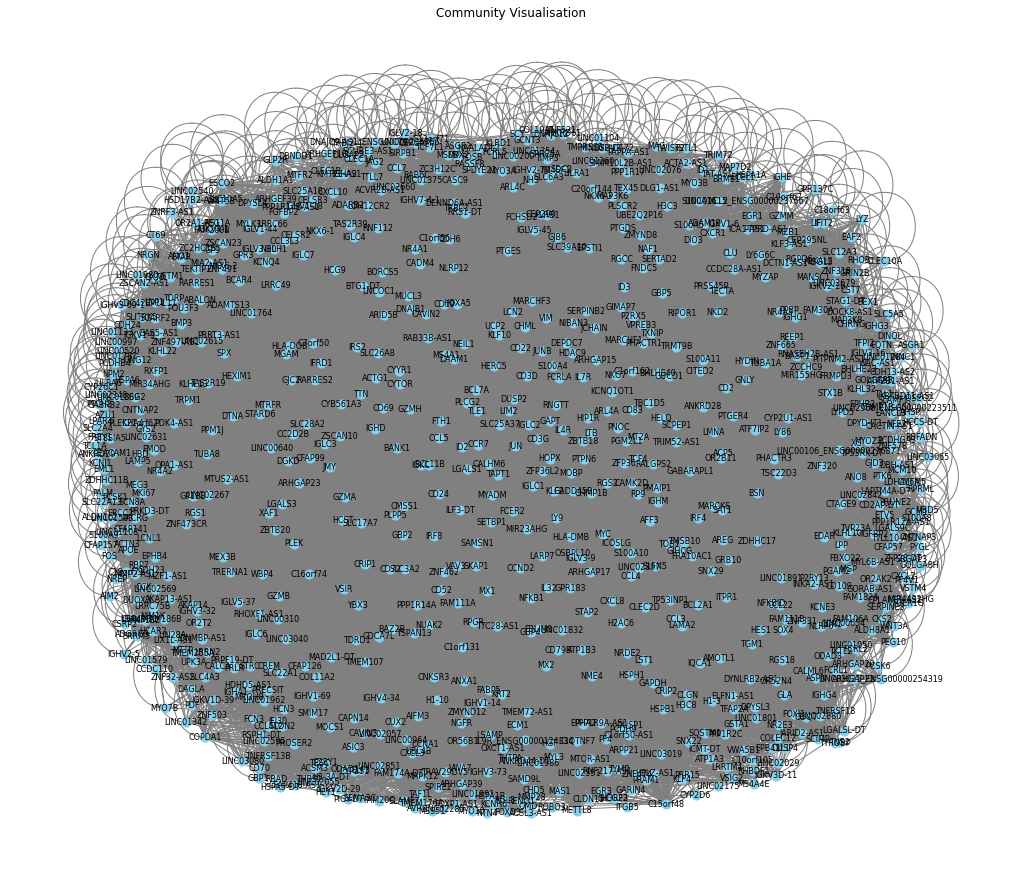

In [45]:
#Step 7:
# Visualise the subgraph
pos = nx.spring_layout(subgraph2, k=0.8, iterations=20)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(subgraph2, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.1, font_size=8)
plt.title('Community Visualisation')
plt.show()